This notebook will use monte-carlo techniques to reveal the expected outcome of each simulated scenario

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from matplotlib import animation, rc
from IPython.display import HTML
from tqdm import tqdm
rc('animation', html='jshtml')

In [2]:
#The following will simulate that the proportion P will have preventative medicine.]
#With an effectiveness of prevention of E per exposure
def sim(N=100, a = 2.0, steps=100, mu=0.1, I=1, R=10, P=0.5, E=0.5, dist=0.02, inc=5, 
       behav="levy"):
    #I is the number of infected at t = 0
    #R is the number of timesteps it takes to recover or die
    #dist is the "contact" range
    
    colors = np.zeros((steps + 1, N)) #Visually signify the states of the model
    r_time = np.zeros((steps + 1, N))
    walkers = np.zeros((steps + 1, N, 2)) #N walkers with 2-D coordinates describing their location
    i_num = 256
    r_num = 128
    p_num = 64
    
    #Initialize the infected
    for j in range(I):
        colors[0][j] = i_num
        colors[1][j] = i_num
        r_time[0][j] = R + inc
    
    for j in range(int(N*P)):
        colors[0][N-j-1] = p_num
        colors[1][N-j-1] = p_num
            
    for t in range(steps):
        if t == 0:
            walkers[0] = np.random.uniform(-a, a, (N , 2))
            continue
        colors[t] = colors[t-1]
        for i in range(N):
            #Generate a random number between 0 & 2pi
            angle = np.random.rand() * 2 * np.pi
            
            step = 0
            if behav is "levy":
                step = np.random.exponential(mu)
            elif behav is "uniform":
                step = np.random.rand()*2*mu
            elif behav is "normal":
                step = np.random.normal(mu, 0.01)
            else: #No varying stepsize
                step = mu
                
            newX = walkers[t - 1][i][0] + np.sin(angle)*step 
            newY = walkers[t - 1][i][1] + np.cos(angle)*step
            newX = max(min(newX, a), -a)
            newY = max(min(newY, a), -a)
            walkers[t][i][0] = newX
            walkers[t][i][1] = newY
        
        #state check.. update infected
        current_walkers = walkers[t]
        exposed = np.zeros(N)
        for i in range(N):
            if colors[t][i] == i_num: #If you are infected
                r_time[t][i] = r_time[t-1][i] - 1 #Increment Recovery
                if r_time[t][i] <= R:
                    distances = current_walkers - current_walkers[i] #Find those you exposed
                    distances = np.sum(np.square(distances), axis=-1)
                    distances = np.where(distances <= np.square(dist), 1, 0)
                    exposed += distances #Add the exposed to the exposed list
                
        for i in range(N):
            if r_time[t][i] < 0.0: #If your recovery time has ended
                colors[t][i] = r_num
            else:
                if exposed[i] > 0.0:
                    if colors[t][i] == 0.0: #If the exposed individual is vulnerable
                        colors[t][i] = i_num
                        r_time[t][i] = R
                    if colors[t][i] == p_num: #If the exposed is taking medication
                        prob_infect = 1 - (E)**exposed[i]
                        if np.random.rand() <= prob_infect:
                            colors[t][i] = i_num
                            r_time[t][i] = R
    return walkers, colors

In [3]:
def update_plot(t, offset, colors, scat):
    scat.set_offsets(offset[t])
    scat.set_array(colors[t])
    num_infected = sum(colors[t] == 256) # 256 is infected number
    num_recovered = sum(colors[t] == 128) # 128 is recovered number
    num_medicated = sum(colors[t] == 64) #64 is medicated number
    num_vulnerable = sum(colors[t] == 0) # 0 is the default number
    counts[0].set_text(f"infected: {num_infected}")
    counts[1].set_text(f"recovered: {num_recovered}")
    counts[2].set_text(f"vulnerable: {num_vulnerable}")
    counts[3].set_text(f"medicated: {num_medicated}")
    return scat

def plot_infection(colors, steps):
    X = []
    Y = []
    for t in range(steps):
        X.append(t)
        infected = np.where(colors[t] == 256, 1, 0)
        infected = np.sum(infected) / len(infected)
        Y.append(infected)
        
    return X, Y

In [4]:
sims = int(1e4) #Number of simulations

#Hyperparameters for simulations (Population Density assumed to be 2455 per square mile)
a = np.sqrt(100/2455)/2 #Simulate 100/2455 sq miles to get appropriate density
N = 100 #Number of people
steps = 100 #Number of time steps
R = 17 #Onset of Symptoms to Recovery/Death
inc = 5 #Incubation period of virus after infection
dist = 19.685/5280.0 #Proximity for Exposure (6ft)
mu =  100/5280.0 #Average size of movement
mr = 8969.0/85745.0 #Mortality rate among infected individuals
P = 0.45 #Proportion taking medicine
E = 0.88 #Effectiveness per exposure

In [5]:
def monte_carlo_sim(a, N, steps, R, dist, mu, P, E, inc, behav="uniform", sims=int(1e2)):
    Y = [] #Running Sum
    Y_sq = [] #Running Square Sum
    for i in tqdm(range(sims)):
        #Simulate
        _, colors = sim(N=N, a=a, steps=steps, R=R, dist=dist, mu=mu,
                                       P=P, E=E, behav=behav, inc=inc)
        x, y = plot_infection(colors, steps) #Get metadata
        #Calculate running moments
        if i == 0:
            x = np.array(x)
            y = np.array(y)
            X = x
            Y = y
            Y_sq = np.square(y)
        else:
            y = np.array(y)
            Y += y
            Y_sq += np.square(y)
            
    return X, Y, Y_sq

In [6]:
def plot_error(X, Y, Y_sq, behav, c=0):
    Y_avg = Y/sims
    Y_std = np.sqrt((Y_sq - (np.square(Y)/sims))/sims)
    plt.errorbar(X, Y_avg, yerr=(2*Y_std))
    plt.xlim(0, 100)
    plt.ylim(0, 0.7)
    plt.xlabel("Time (Days)")
    plt.ylabel("Percent of People Infectious (Contagious)")
    plt.title("Expected Infection over " + str(sims) + " simulations for " + behav)
    plt.show()

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:00<00:00, 10.41it/s]
c:\users\philip felizarta\.conda\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


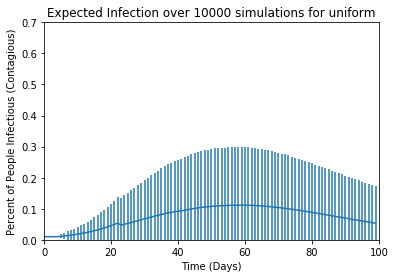

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [18:41<00:00,  8.91it/s]


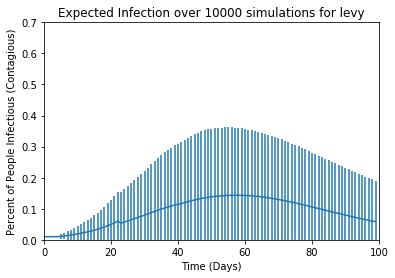

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:58<00:00, 11.93it/s]


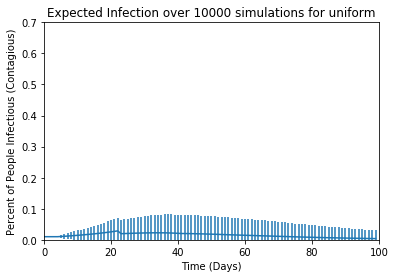

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [16:06<00:00, 10.35it/s]


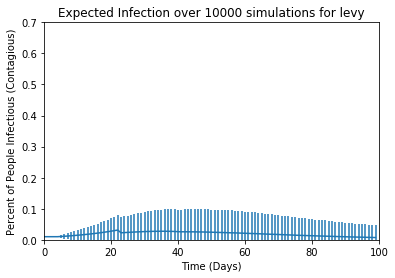

In [7]:
X, Y, Y_sq = monte_carlo_sim(a, N, steps, R, dist, mu, 0.0, 0.0, inc, behav="uniform", sims=sims)
plot_error(X, Y, Y_sq, "uniform", c=0)
X, Y, Y_sq = monte_carlo_sim(a, N, steps, R, dist, mu, 0.0, 0.0, inc, behav="levy", sims=sims)
plot_error(X, Y, Y_sq, "levy", c=64)
X, Y, Y_sq = monte_carlo_sim(a, N, steps, R, dist, mu, P, E, inc, behav="uniform", sims=sims)
plot_error(X, Y, Y_sq, "uniform", c=128)
X, Y, Y_sq = monte_carlo_sim(a, N, steps, R, dist, mu, P, E, inc, behav="levy", sims=sims)
plot_error(X, Y, Y_sq, "levy", c=256)